#**Step 1: Install All the Required Packages**

In [1]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unsloth-zoo 2025.5.7 requires accelerate>=0.34.1, but you have accelerate 0.21.0 which is incompatible.
unsloth-zoo 2025.5.7 requires peft!=0.11.0,>=0.7.1, but you have peft 0.4.0 which is incompatible.
unsloth-zoo 2025.5.7 requires transformers!=4.47.0,==4.51.3, but you have transformers 4.31.0 which is incompatible.
unsloth-zoo 2025.5.7 requires trl!=0.15.0,!=0.9.0,!=0.9.1,!=0.9.2,!=0.9.3,<=0.15.2,>=0.7.9, but you have trl 0.4.7 which is incompatible.
unsloth 2025.5.6 requires accelerate>=0.34.1, but you have accelerate 0.21.0 which is incompatible.
unsloth 2025.5.6 requires peft!=0.11.0,>=0.7.1, but you have peft 0.4.0 which is incompatible.
unsloth 2025.5.6 requires transformers!=4.47.0,==4.51.3, but you have transformers 4.31.0 which is incompatible.
unsloth 2025.5.6 requires trl!=0.15.0,!=0.9.0,!=0.9.1,!=0.9

#**Step 2: Import All the Required Libraries**

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

#**In case of Llama 2, the following prompt template is used for the chat models**

System Prompt (optional) to guide the model


User prompt (required) to give the instruction


Model Answer (required)

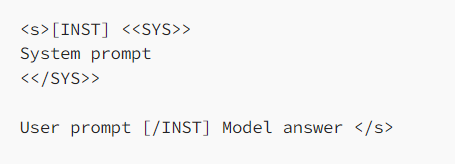

In [3]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-chat-hf"

# The instruction dataset to use
dataset_name = "mlabonne/guanaco-llama2-1k"

# Fine-tuned model name
new_model = "Llama-2-7b-chat-finetune"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

In [9]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "What is a large language model?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] What is a large language model? [/INST] A large language model is a type of artificial intelligence (AI) model that is trained on a large dataset of text to generate human-like language outputs. everybody is talking about the large language models, but what are they?

Large language models are neural networks that are trained on vast amounts of text data to predict the next word in a sequence of text. They are called "large" because they are trained on billions of words, and they are called "language models" because they are designed to predict the next word in a sequence of text.

Large language models are trained on vast amounts of text data, such as books, articles, and websites. They are designed to predict the next word in a sequence of text, and they are trained to do this by learning the patterns and structures of language.

Large language models are used in a variety of applications, such as chatb


In [10]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

20933

In [11]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [1]:
# fine_tune_text_age.py – RunPod‑ready script for dating historical texts with Llama‑2
# -------------------------------------------------------------------
# Copy/paste this file into a RunPod/Jupyter cell **or** run it as:
#     !python fine_tune_text_age.py
# -------------------------------------------------------------------
# It auto‑detects your local 🤗 Transformers version and passes only the
# TrainingArguments that exist in that version (so you won’t hit the
# “unexpected keyword argument 'evaluation_strategy'” error again).
#
# 🔄 2025‑05‑19 update: custom collator pads **labels** as well so their
#    length now always matches `input_ids`, fixing the ValueError:
#       "Expected input batch_size (x) to match target batch_size (y)".
# -------------------------------------------------------------------

import os
import logging
import inspect
from dataclasses import dataclass, field
from typing import Optional, Dict, List

import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# ---------------------------
# 1️⃣  Hyper‑parameters (edit)
# ---------------------------
@dataclass
class Config:
    # Data
    csv_path: str = "textage_small.csv"          # ⬅️ your CSV already on the VM
    text_col: str = "text"                       # column with the passage
    label_col: str = "date"                      # column with the 4‑digit year
    test_split: float = 0.05                      # 5 % for validation

    # Model + tokenizer
    model_name: str = "NousResearch/Llama-2-7b-chat-hf"
    max_length: int = 512                         # truncation length
    pad_to_multiple_of: int = 8                   # pad sequences to mult‑of‑8

    # LoRA
    lora_r: int = 16
    lora_alpha: int = 32
    lora_dropout: float = 0.05
    target_modules: List[str] = field(default_factory=lambda: [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ])

    # Training
    output_dir: str = "./text_age_lora"
    num_train_epochs: int = 3
    per_device_train_batch_size: int = 1
    gradient_accumulation_steps: int = 8          # effective batch = 8
    learning_rate: float = 2e-4
    warmup_steps: int = 100
    logging_steps: int = 25
    save_steps: int = 250
    eval_steps: int = 250
    fp16: bool = False                            # use bf16 if GPU supports
    bf16: bool = torch.cuda.is_available() and torch.cuda.is_bf16_supported()

cfg = Config()

# ---------------------------
# 2️⃣  Logging
# ---------------------------
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)
logger.info("🐑 Using device: %s", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# ---------------------------
# 3️⃣  Tokenizer (fast)
# ---------------------------
logger.info("🔑 Loading tokenizer…")

kwargs_tok = {"use_fast": True, "add_eos_token": True}

try:
    tokenizer = AutoTokenizer.from_pretrained(cfg.model_name, **kwargs_tok)
except TypeError:  # extremely old transformers versions
    kwargs_tok.pop("use_fast")
    tokenizer = AutoTokenizer.from_pretrained(cfg.model_name, **kwargs_tok)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# ---------------------------
# 4️⃣  Dataset → prompt → token IDs
# ---------------------------
logger.info("📚 Loading CSV %s", cfg.csv_path)

raw_ds = Dataset.from_csv(cfg.csv_path)
assert cfg.text_col in raw_ds.column_names and cfg.label_col in raw_ds.column_names, (
    f"Columns {cfg.text_col} / {cfg.label_col} not found.")

raw_ds = raw_ds.train_test_split(test_size=cfg.test_split, seed=42)

PROMPT_TEMPLATE = (
    "<s>[INST] You are an expert historian. Given the passage below, "
    "return ONLY the 4‑digit year. [/INST]\n{text}\n"
)

def build_example(example: Dict[str, str]) -> Dict[str, List[int]]:
    prompt = PROMPT_TEMPLATE.format(text=example[cfg.text_col])
    prompt_ids = tokenizer(
        prompt,
        truncation=True,
        max_length=cfg.max_length - 5,   # reserve for label + EOS
        add_special_tokens=False,
    )["input_ids"]

    label_ids = tokenizer(str(example[cfg.label_col]), add_special_tokens=False)["input_ids"]
    label_ids.append(tokenizer.eos_token_id)

    input_ids = prompt_ids + label_ids

    # Mask prompt; train only on label tokens
    labels = [-100] * len(prompt_ids) + label_ids

    return {
        "input_ids": input_ids,
        "attention_mask": [1] * len(input_ids),
        "labels": labels,
    }

logger.info("📝 Tokenising …")
proc_ds = raw_ds.map(build_example, remove_columns=raw_ds["train"].column_names, batched=False)

# ---------------------------
# 5️⃣  Custom collator that pads **input_ids, attention_mask, labels**
# ---------------------------
class CausalLMCollator:
    """Pad everything to the longest seq in the batch, then to multiple‑of‑N."""

    def __init__(self, tok, pad_to_multiple_of: int | None = None):
        self.tok = tok
        self.mult = pad_to_multiple_of

    def __call__(self, features: List[Dict[str, List[int]]]) -> Dict[str, torch.Tensor]:
        # find longest seq
        max_len = max(len(f["input_ids"]) for f in features)
        if self.mult:
            remainder = max_len % self.mult
            if remainder:
                max_len += self.mult - remainder

        batch = {}
        for name in ("input_ids", "attention_mask", "labels"):
            pad_id = self.tok.pad_token_id if name != "labels" else -100
            padded = [f[name] + [pad_id] * (max_len - len(f[name])) for f in features]
            batch[name] = torch.tensor(padded, dtype=torch.long)
        return batch

collator = CausalLMCollator(tokenizer, pad_to_multiple_of=cfg.pad_to_multiple_of)

# ---------------------------
# 6️⃣  Model + LoRA
# ---------------------------
logger.info("🦙 Loading base model… (8‑bit)")

model = AutoModelForCausalLM.from_pretrained(
    cfg.model_name,
    load_in_8bit=True,
    device_map="auto",
)

model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=cfg.lora_r,
    lora_alpha=cfg.lora_alpha,
    target_modules=cfg.target_modules,
    lora_dropout=cfg.lora_dropout,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# ---------------------------
# 7️⃣  TrainingArguments (auto‑filtered)
# ---------------------------

# Full list with modern keys
ta_kwargs = dict(
    output_dir=cfg.output_dir,
    num_train_epochs=cfg.num_train_epochs,
    per_device_train_batch_size=cfg.per_device_train_batch_size,
    gradient_accumulation_steps=cfg.gradient_accumulation_steps,
    learning_rate=cfg.learning_rate,
    warmup_steps=cfg.warmup_steps,
    bf16=cfg.bf16,
    fp16=cfg.fp16 and not cfg.bf16,
    logging_steps=cfg.logging_steps,
    save_steps=cfg.save_steps,
    evaluation_strategy="steps",
    eval_steps=cfg.eval_steps,
    save_total_limit=3,
    report_to="none",
)

accepted = inspect.signature(TrainingArguments.__init__).parameters
filtered_kwargs = {k: v for k, v in ta_kwargs.items() if k in accepted}
missing = set(ta_kwargs) - set(filtered_kwargs)
if missing:
    logger.warning("⚠️  Dropping unsupported TrainingArguments: %s", ", ".join(missing))

train_args = TrainingArguments(**filtered_kwargs)

# ---------------------------
# 8️⃣  Trainer
# ---------------------------
trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=proc_ds["train"],
    eval_dataset=proc_ds["test"],
    data_collator=collator,
)

# ---------------------------
# 9️⃣  Train!
# ---------------------------
if __name__ == "__main__":
    logger.info("🚀 Starting fine‑tuning…")
    trainer.train()

    logger.info("💾 Saving LoRA adapter to %s", cfg.output_dir)
    model.save_pretrained(cfg.output_dir)
    tokenizer.save_pretrained(cfg.output_dir)

    logger.info("✅ Done!")


2025-05-19 09:10:29,836 - INFO - 🐑 Using device: NVIDIA GeForce RTX 4090
2025-05-19 09:10:29,837 - INFO - 🔑 Loading tokenizer…
2025-05-19 09:10:30,062 - INFO - 📚 Loading CSV textage_small.csv
2025-05-19 09:10:30,096 - INFO - 📝 Tokenising …


Map:   0%|          | 0/2185 [00:00<?, ? examples/s]

Map:   0%|          | 0/115 [00:00<?, ? examples/s]

2025-05-19 09:10:33,319 - INFO - 🦙 Loading base model… (8‑bit)
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
2025-05-19 09:10:33,640 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2025-05-19 09:10:47,388 - WARNING - ⚠️  Dropping unsupported TrainingArguments: evaluation_strategy
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
2025-05-19 09:10:47,417 - INFO - 🚀 Starting fine‑tuning…


trainable params: 39,976,960 || all params: 6,778,392,576 || trainable%: 0.5898


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 d

Step,Training Loss
25,3.353200
50,1.064500
75,0.797800
100,0.754900
125,0.688900
150,0.688900
175,0.655100
200,0.585500
225,0.612000
250,0.549800


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to 

2025-05-19 11:28:23,763 — INFO — Device: cuda
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
2025-05-19 11:28:24,226 — INFO — We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(



Saved per-row results → results.csv

First 10 rows:
• 'At length they were all divided into two Factions The [...]'
  raw → '1683'
  pred_year=1683

• 'pee Drusilla in these her Country Accoutrements seemed [...]'
  raw → '1700'
  pred_year=1700

• 'moue hert nor hande but at his co maundement bycausehe [...]'
  raw → '1535'
  pred_year=1535

• 'be loued that he gyueth vnto vs his ryght precyous [...]'
  raw → '1493'
  pred_year=1493

• 'with a sudden jerk and she roused herself up and [...]'
  raw → '1863'
  pred_year=1863

• 'Denmark to resign all his pretensions to the dutchy of [...]'
  raw → '1771'
  pred_year=1771

• 'more admirably situated and as I sauntered about it [...]'
  raw → '1913'
  pred_year=1913

• 'forthe he went aboute ymagyned ordayned and onely [...]'
  raw → '1525'
  pred_year=1525

• 'the weye of the roche wher vpon he wasmou tid and than [...]'
  raw → '1473'
  pred_year=1473

• 'by the Emprours so that some moved the kyng to take [...]'
  raw → '1543'
  pred_

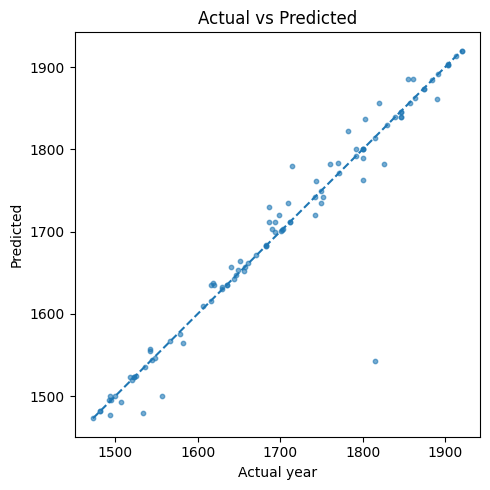

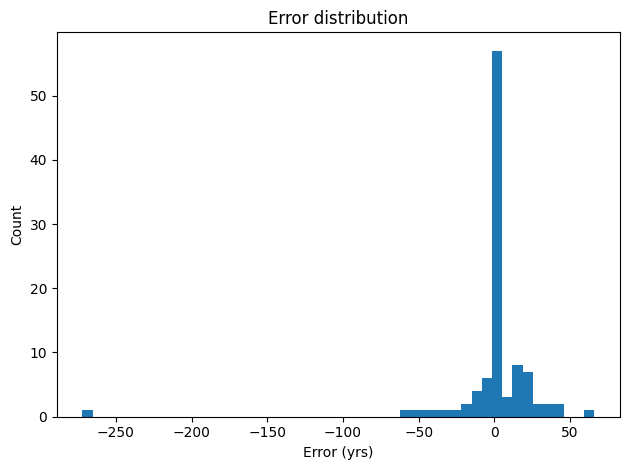

In [1]:
# evaluate_text_age_debug.py  – prints & saves raw generations
import os, re, argparse, json, logging, textwrap
from pathlib import Path

import torch, pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel


PROMPT_TEMPLATE = (
    "<s>[INST] You are an expert historian. Given the passage below, "
    "return ONLY the 4-digit year. [/INST]\n{text}\n"
)


def build_prompt(text: str) -> str:
    return PROMPT_TEMPLATE.format(text=text)


# ---------------------- year extractor ----------------------
# matches a 4-digit number between 1000-2030, ignoring punctuation & words
YEAR_RE = re.compile(r"(1[0-9]{3}|20[0-2][0-9]|2030)")

def extract_year(raw: str) -> int | None:
    txt = raw.lower().replace(",", " ").replace("-", " ")
    # strip common phrases that sometimes precede the number
    for lead in ("the year is", "the passage is from", "likely written in"):
        if lead in txt:
            txt = txt.split(lead, 1)[-1]
    m = YEAR_RE.search(txt)
    return int(m.group()) if m else None


from inspect import signature

def _rmse(y_true, y_pred):
    sig = signature(mean_squared_error)
    if "squared" in sig.parameters:            # modern sklearn
        return mean_squared_error(y_true, y_pred, squared=False)
    else:                                      # legacy sklearn
        return np.sqrt(mean_squared_error(y_true, y_pred))




# ---------------------- metrics helper ----------------------
def compute_metrics(df: pd.DataFrame, path: Path) -> None:
    valid = df.dropna(subset=["pred_year"])
    if valid.empty:
        print("\n⚠️  All predictions are NaN – check regex or generations.\n")
        return

    y_true, y_pred = valid["date"].astype(int), valid["pred_year"].astype(int)

    metrics = {
        "MAE":      mean_absolute_error(y_true, y_pred),
        "RMSE":     _rmse(y_true, y_pred),
        "R2":       r2_score(y_true, y_pred),
        "ExactAcc": (y_true == y_pred).mean(),
        "Acc±10yr": (np.abs(y_true - y_pred) <= 10).mean(),
    }
    path.write_text(json.dumps(metrics, indent=2))
    for k, v in metrics.items():
        print(f"{k:10}: {v:.4f}")
    print(f"Metrics saved → {path}")



# ---------------------- main ----------------------
def main(args):
    logging.basicConfig(level=logging.INFO,
                        format="%(asctime)s — %(levelname)s — %(message)s")
    log = logging.getLogger("EVAL")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    log.info("Device: %s", device)

    # model
    tok = AutoTokenizer.from_pretrained(args.adapter_dir)
    base = AutoModelForCausalLM.from_pretrained(
        "NousResearch/Llama-2-7b-chat-hf",
        device_map="auto", load_in_8bit=True)
    
    model = PeftModel.from_pretrained(base, args.adapter_dir)
    model.eval()

    # data
    df = pd.read_csv(args.csv_path)
    assert {"text", "date"}.issubset(df.columns)

    preds, raws = [], []
    BATCH = args.batch_size

    with torch.no_grad():
        for i in range(0, len(df), BATCH):
            rows = df.iloc[i:i+BATCH]
            inputs = tok([build_prompt(t) for t in rows["text"]],
                         return_tensors="pt", padding=True).to(device)

            gen = model.generate(**inputs, max_new_tokens=6,
                                 temperature=0.0, do_sample=False)
            outs = tok.batch_decode(
                gen[:, inputs["input_ids"].shape[1]:],
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True)

            raws.extend(outs)
            preds.extend(extract_year(o) for o in outs)

    # results dataframe
    assert len(preds) == len(df)
    df["raw_gen"] = raws
    df["pred_year"] = preds
    df["error"] = df["pred_year"] - df["date"]

    # save + preview
    Path(args.out_csv).parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(args.out_csv, index=False)
    print(f"\nSaved per-row results → {args.out_csv}\n")

    print("First 10 rows:")
    for _, row in df.head(10).iterrows():
        snippet = textwrap.shorten(row["text"], 60)
        print(f"• {snippet!r}\n  raw → {row['raw_gen']!r}\n  pred_year={row['pred_year']}\n")

    # metrics
    metrics_path = Path(args.out_csv).with_suffix(".metrics.json")
    compute_metrics(df, metrics_path)

    # plots only if we have >0 valid rows
    if df["pred_year"].notna().any():
        valid = df.dropna(subset=["pred_year"])
        y_true, y_pred = valid["date"].astype(int), valid["pred_year"].astype(int)

        plt.figure(figsize=(5,5))
        plt.scatter(y_true, y_pred, alpha=.6, s=10)
        lo, hi = y_true.min(), y_true.max()
        plt.plot([lo, hi], [lo, hi], ls="--")
        plt.xlabel("Actual year"); plt.ylabel("Predicted")
        plt.title("Actual vs Predicted"); plt.tight_layout()
        plt.savefig("scatter.png", dpi=150)

        plt.figure()
        plt.hist(valid["error"], bins=50)
        plt.xlabel("Error (yrs)"); plt.ylabel("Count")
        plt.title("Error distribution"); plt.tight_layout()
        plt.savefig("error_hist.png", dpi=150)

        print("Plots saved: scatter.png, error_hist.png")


# -------------- CLI --------------
if __name__ == "__main__":
    ap = argparse.ArgumentParser()
    ap.add_argument("--csv_path",    default="textage_test_small.csv")
    ap.add_argument("--adapter_dir", default="./text_age_lora")
    ap.add_argument("--out_csv",     default="results.csv")
    ap.add_argument("--batch_size",  type=int, default=4)
    args, _ = ap.parse_known_args()          # ignore Jupyter’s -f flag
    main(args)


In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
tok   = AutoTokenizer.from_pretrained("./text_age_lora")
base  = AutoModelForCausalLM.from_pretrained("NousResearch/Llama-2-7b-chat-hf",
                                             load_in_8bit=True, device_map="auto")
model = PeftModel.from_pretrained(base, "./text_age_lora").eval()



The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
#passage = "pee Drusilla in these her Country Accoutrements seemed almost a stranger to her self and her Ruddy Countenance though it were not so Course from its freshness of Complexion seemed to humour the disguise Eyes black as Sloes with Cherry Lips and Cheeks like Katherine Pear That cry not only Kiss my Love but Eat me up my Dear 'T would tempt not only Country Swains but anySwitzerhere In thisAutumnalorRustickdress she trips away to the Temple much about the time the Young Girls of the Neighbouring Villages used to come to gaze about the Quire and at last fixing their Eyes on thefinestFace that has theloudestVoice devoutly listen to theVocalMusick of the Church till thelouder OrganAlarms them to turn about and look another way butDrusilla better acquainted with the Service and Ceremony had other Contemplations Her Eyes were fixed on the Comely Stranger and it was not long before the Fair Stranger had found out hers and though he was more Devoutly engaged in his Contemplations ofhis more admiredVicentina than at her Devotions yet whether by Instinct or wandring of his looks and thoughts is not so certain he could not forbear regarding this Country Damosel with a concern of which then he could not comprehend the Reason but much more surprized he was when the Service ended and this delicate and unknown Dame presented him with a simp'ring look and low Court'sy these humble Lines Sir BE not surprized at the strangeness of this Address 'tis in your power to make your self the happiess Man living follow your Fortune where you Love you are as much beloved lose no opportunity lest you repent your neglect and delay and so b Wise too late manage your Affair with Prudence let your first Visits b secret and if your Love be warm be confident it will find no cold Reception Sir Your hearty Friend and well wisher D WHILE theEager Armadorusfull ofwonderand admiration wasanxiouslyrunning over these Mysterious Lines and ready to break out into passion and Expostulation the cunningDrusillahad withdrawn her self in the Crowd and so added another piece ofwondring to his perfect Astonishment And am I then said he made a Riddle to my self Or this place someFairy Ground Holy Groundit is and Dedicated to some Sublimer Deity and theresore no such Fantastick Scenes Airy Phantoms and Foolish Enchantments can take place here This cannot come from my AdmiredVicentina but some Country Beauty that perhapsmy person though so unworthy has seem'd acceptable and agreeable to The Countess that has Charm'd me keeps no such Domesticks and this Gallant City yields no such plain Rusticity but yet me thoughts muchInnocencyandSweetnessseemed to dwell under thathomely simplicity and were I Master of that Heart which once I had when the Field and the Camp afforded me the only delight soprettysofresha Creature just come from the Country could hardly have got off so easily butpurerLove and now moresacredthoughts possess my breast which though not tainted with theleastof sin I am sure I find to be thegreatesttorment But why after all this may not"
#passage = "be loued that he gyueth vnto vs his ryght precyous blode for too drynke and his dygne and precyous flesshe for to ete Therfore remembreth vs so oft saynt Poule this loue whiche he sheweth vnto vs For a more quicker reason ne more fayrer example may he not shewe vnto vs of veray amyte and frendshyp yf so be that thou thynke well and stedfastly on these toforesayd reasons Thou shalte fynde vii degreesof amytye and frendshyppes the whiche cometh of the gyftes of pyte Of vii maners of spyrytuell loue Ca Cix OF this stocke and oute of this rote growen vii braunches For this vertue sheweth hy in seuen maners lyke as loue is knowen whiche is emonge the membres of a body in vii maners Fyrst the one of the membres kepeth and countregardeth the other that it do to hym none euyll ne that it faylle hym not ne that it doo hym none harme ne domage to his power and herin we vnderstonde our Innocency whiche we ought to kepe eche anenst other For this commaundement is wryton in yeherte of euery persone That is that thou do to another after god that whiche thou woldest that he dyd to the and that thou sholdest not do to another otherwyse tha thou woldest sholde not be doone to the Ne yethy ryght honde sholde smyte the lyft honde Also that one membre suffre swetely that other that it doo to it no harme ne no vengeaunce ne wrathe But yf that one membre haue harme or hurte that other membres fele it And in this vnderstonde we parfyght debonayrte whiche hath iii degrees The fyrst is that he reuenge hym not The seconde that he reteyne not wrathe ne yre The thyrde that he ne fele no moeuynge of hate ne yre towarde his neyghboure for ony thynge that he doth Also yemembres obeyen al to theyr souerayn For they do al to theyr power that whiche the herte comaundeth them and yeeyen ensygnen them In this vnderstonde we yevertue of obedyence of whiche we haue spoken tofore whicheought for to be apparaylled and aourned in loue and in charyte as lyke as sayth saynt Peter the appostle Also that one membre helpeth that other and serueth that other without daunger or peryll without contradyccion and without auaryce And herin we vnderstande yevertue the whiche is called charyte of whiche a man then e helpeth and socoureth an other gladly with the power yegod hath gyuen hym or he ensygneth or counceyleth wtthe wytte that he hath Or he gyueth and departeth largely for the loue of god the goodes and rychesses that he hath Thenne is sayd of hym that he is moche charytable and thus commaundeth to vs saynt Peter that the graces ytalmyghty god hath gyuen vnto vs that we admynyster theym vnto our neyghboures and prochanes wherof Tullius yephylosophre sayth we ought to fele al that whiche is in yeworlde and groweth and encreaseth all is made for to serue man Andquayersleyda partandin two yere aftyrlabouredno more in thys werkeAndwas fully in wyll to haue lefte hyt tyll on a tyme hitfortunedthat the ryght hyghe excellentandright vertuous prynces my ryghtredoughtedlady mylady Margarete by the grace ofgodsuster vnto ekynge ofenglondandof fra ce my soueraynlordDuchesse of Bourgoine of lotryk of brabant of lymburgh andof luxenburgh Countes of ffla dres of artoys of bourgoine Palatynee ofheynawdofholandofzela dand of namur Mar uesse of eholy empire lady of ffryse of salius and of mechlyn sente for me to speke wyth her good grace of dyuerce maters among ewhyche y lete her hyenes haue knowleche of eforsayd begynnyng of thys werke whiche anone comanded me to shewe the sayd v or vi quayers to her sayd grace and whan she had seen hem anone she fonde a defaute in myn englissh whiche sche coma ded me to amende a d more ouer comanded me straytli to contynue and make an ende of the resydue than not translated whosdredefullcoma dement y durste in no wyse disobey because y am a serua t vnto her sayde graceandresseiue of her yerly ffee and other many goode and grete benefetes andalso hope many moo to resseyne of her hyenes but forthwyth wente and labouryde in the sayde translacion aftyr my symple and pour connyng also nigh as y can folouyng myn auctour mekeli besechingthe bounteuous hyenes of mysaidlady that of her benyuolence lifte to accepte take in gree this symple rude werke here folowyng andyf ther be ony thyng wreton orsaydto her playsir y shall thynke my labourwellenployedandwhere as ther is defawte tshe arette hyt to esymplenes of my connyng whiche is fulsmallin this behalueandrequyre praye alle them that shall rede thissaydwerke to correcte hyt toholdmeexcusidof the rude symple translacionAndthus y ende my prologe HEre foloweth e logue of that worshipful man Raoul le feure whiche was Auctor of this present book in the ffrensh tonge WHan ybehold knowe the oppynyone of the mennourisshydin ony synguler hystoryes of Troyeandseeandbeholde also that of then to make a recuyel or gadryng to geder y indigne haueresseyuedthe comandement of the ryght nobleandright vertuous prynce Philippe by the grace of emaker of alle graces Duc of borgoyne of lothryk ofBrabandandof Lymbourgh Erle of fflaunders of Artoysandof Bourgoyne Palatyne ofheynawdofHollandofIelandandof namur Marquys of eholy EmpyreLordof fryse of salyns and of mechlyn Certes yfyndynowh for to thenke on for of ehistoryes wherof y wyl make erecuyel Alle eworldspeketh of them by bookes tra slated out of latin in to ffresh a grete dele lasse than y ne shall trete And some ther be treplye a gayn their ticuler bookes wherfore y fere me to wryte more than her bookesmake mencion But whan y consydere poyse weye thedredfullcomandement of the forsayderedoubtydprynce whyche is cause of thys werke not for to correcte the bookys late solempnlytranslated but onely for to augmente y yelde me obeissau t a dfor theschuyng of the lasseeuyllthat y may y shall make thre bookes whiche put in one schall take for name theRecuyellof the troia n historyes In the fyrst booke y schall trete of Saturneandof"
#passage = "moue hert nor hande but at his co maundement bycausehe hathe fyrste created vs of nought and heuen and erthe for oure sakes And afterward whan we had marred our selfe thorowe synne he forgaue vs and created vs agayne in the blode of his beloued sonne And that we haue yename of our one god in feare reuerence that we dishonoure it nat in swearynge therby about lyght trysles or vanite or call it to recorde for the co fyrmi g of wickednes or falshed or ought that is to the dyshonoure of God which is the brekynge of his lawes or vnto the hurte of our neighbour And inasmoch as he is our lorde and god and we his double possessyon by creacion redemption and therfore ought as I said neither to moue hert or hande without his co mau deme t it is right that we haue nedefull holyedayes to come togyther lerne his wyll both the lawewhich he wyl haue vs ruled by also the promyses of mercy which he wyll haue vs trust vnto to gyue god tha kes togyther of his mercy and co mytte our infyrmities to him thorow our sauyour Jesus to reconsyle our selues vnto him eche to other if ought be betwene brother brother that requyreth it And for this purpose suche lyke as to vyset the sycke nedy and redresse peace vnyt e were the holydayes ordeyned only so farforth ar they to be kepte holy from al maner workes that may be co uenyently spared for the tyme tyll this be done and no further but than laufully to worke And that it is right that we obey father and mother mayster lorde prince kynge all the ordynaunces of the worlde bodily and gostly by whiche god ruleth vs and ministreth frely his benefyt vnto vs al And that we loue them for the benefytes that we receyue by the fere them for the power they haue ouer vs to punyssh vs if we trespace the lawe and good ordre So farre yet ar the worldly powers or rulers to be obeyed onely as their co mau dementes repugne nat agaynst the co maundement of god and than ho Wherfore we must haue goddes co maundement euer in our hertes by the hyer lawe interprete the inferyor that we obey nothi ge against the belefe of our god or agaynst the faith hope and trust that is in him only or agaist the loue of god wher by we do or leaue vndone all thing for his sake that we do nothinge for any mans co mau deme t against the reuerence of the name of god to make it dispysed and the lesse fered and set by that we obeye nothinge to the hynderaunce of the knowlege of the blessed doctryne of god whose seruaunt the holye daye is Nat withstandynge though the rulers whiche god hath set ouer vs commaunde vs against god or do vs ope wronge oppresse vs with cruell tyra ny yet bycause they are"
#passage = "ythe ment to poyson him being hired so to doe byDarius For the next phisicke he had n ede of he caused the samePhilipto make him a p tion and taking the same with one hand deliueredPhilipthe letter that accused him with the other drinking of the potion without any stay or doubt either then or euer afterward But what shold I trouble you with many of these examples my text is in st ed of ten thousands thousands of them Jesus Christ our Sauiour is constant loueth to the end whome he once loueth casting not away for malice of man or diuill whom once he receiueth being come vnto him Thinke therfore of this let this reforme our wauering wills our tottering loue vnstable affectio s together with that ofSalomon ifPro 17 17 you will Omni tempore diligit qui amicus est He loueth euer that is a true friend And let this suffice I might note a true comfort in this constancieSectaries excommunication of our Sauiour against the blustering threats and thundering excommunications of Pope and papists sectaries and nabaptists who shal neuer be able to hurtsuch as haue the true comfort of their comming to Christ by a liuely faith in their consciences But the time is past The God of heauen giue this which hath b ene spoken his blessing that it may be a sauour of life vnto life to vs and neuer a sauour of death vnto death to the prayse of his name and our eternall comfort through Jesus Christ our Lord Amen Amen"
passage= "pee Drusilla in these her Country Accoutrements seemed almost a stranger to her self and her Ruddy Countenance though it were not so Course from its freshness of Complexion seemed to humour the disguise Eyes black as Sloes with Cherry Lips and Cheeks like Katherine Pear That cry not only Kiss my Love but Eat me up my Dear 'T would tempt not only Country Swains but anySwitzerhere In thisAutumnalorRustickdress she trips away to the Temple much about the time the Young Girls of the Neighbouring Villages used to come to gaze about the Quire and at last fixing their Eyes on thefinestFace that has theloudestVoice devoutly listen to theVocalMusick of the Church till thelouder OrganAlarms them to turn about and look another way butDrusilla better acquainted with the Service and Ceremony had other Contemplations Her Eyes were fixed on the Comely Stranger and it was not long before the Fair Stranger had found out hers and though he was more Devoutly engaged in his Contemplations ofhis more admiredVicentina than at her Devotions yet whether by Instinct or wandring of his looks and thoughts is not so certain he could not forbear regarding this Country Damosel with a concern of which then he could not comprehend the Reason but much more surprized he was when the Service ended and this delicate and unknown Dame presented him with a simp'ring look and low Court'sy these humble Lines Sir BE not surprized at the strangeness of this Address 'tis in your power to make your self the happiess Man living follow your Fortune where you Love you are as much beloved lose no opportunity lest you repent your neglect and delay and so b Wise too late manage your Affair with Prudence let your first Visits b secret and if your Love be warm be confident it will find no cold Reception Sir Your hearty Friend and well wisher D WHILE theEager Armadorusfull ofwonderand admiration wasanxiouslyrunning over these Mysterious Lines and ready to break out into passion and Expostulation the cunningDrusillahad withdrawn her self in the Crowd and so added another piece ofwondring to his perfect Astonishment And am I then said he made a Riddle to my self Or this place someFairy Ground Holy Groundit is and Dedicated to some Sublimer Deity and theresore no such Fantastick Scenes Airy Phantoms and Foolish Enchantments can take place here This cannot come from my AdmiredVicentina but some Country Beauty that perhapsmy person though so unworthy has seem'd acceptable and agreeable to The Countess that has Charm'd me keeps no such Domesticks and this Gallant City yields no such plain Rusticity but yet me thoughts muchInnocencyandSweetnessseemed to dwell under thathomely simplicity and were I Master of that Heart which once I had when the Field and the Camp afforded me the only delight soprettysofresha Creature just come from the Country could hardly have got off so easily butpurerLove and now moresacredthoughts possess my breast which though not tainted with theleastof sin I am sure I find to be thegreatesttorment But why after all this may not"
prompt  = ("<s>[INST] You are an expert historian. Given the passage below, "
           "return ONLY the 4-digit year. [/INST]\n" + passage + "\n")

out = model.generate(
    **tok(prompt, return_tensors="pt").to(model.device),
    max_new_tokens=6,              # predict up to 6 new tokens
    do_sample=False                # greedy decoding → no randomness
)

print(tok.decode(out[0], skip_special_tokens=True))
# → 1510


[INST] You are an expert historian. Given the passage below, return ONLY the 4-digit year. [/INST]
pee Drusilla in these her Country Accoutrements seemed almost a stranger to her self and her Ruddy Countenance though it were not so Course from its freshness of Complexion seemed to humour the disguise Eyes black as Sloes with Cherry Lips and Cheeks like Katherine Pear That cry not only Kiss my Love but Eat me up my Dear 'T would tempt not only Country Swains but anySwitzerhere In thisAutumnalorRustickdress she trips away to the Temple much about the time the Young Girls of the Neighbouring Villages used to come to gaze about the Quire and at last fixing their Eyes on thefinestFace that has theloudestVoice devoutly listen to theVocalMusick of the Church till thelouder OrganAlarms them to turn about and look another way butDrusilla better acquainted with the Service and Ceremony had other Contemplations Her Eyes were fixed on the Comely Stranger and it was not long before the Fair Strange